In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Read the dataset

In [2]:

# Load the data
df = pd.read_csv('GDSI_OpenDataset_Final.csv')

# Function to determine if a column is continuous or discrete
def determine_variable_type(column):
    if pd.api.types.is_numeric_dtype(column):
        unique_values = column.nunique()
        if unique_values > 10:  # Arbitrary threshold to distinguish between continuous and discrete
            return 'Continuous'
        else:
            return 'Discrete'
    else:
        return 'Categorical'

# Initialize a dictionary to store the results
variable_types = {}
missingness_percentages = {}

# Iterate through each column in the DataFrame
for column in df.columns:
    variable_types[column] = determine_variable_type(df[column])
    missingness_percentages[column] = df[column].isnull().mean() * 100

# Convert the results to DataFrames for better visualization
variable_types_df = pd.DataFrame(variable_types.items(), columns=['Variable', 'Type'])
missingness_percentages_df = pd.DataFrame(missingness_percentages.items(), columns=['Variable', 'Missingness (%)'])




In [3]:
variable_types_df

,Variable,Type
0,secret_name,Categorical
1,report_source,Categorical
2,age_in_cat,Discrete
3,bmi_in_cat2,Categorical
4,covid19_admission_hospital,Categorical
5,covid19_confirmed_case,Categorical
6,covid19_diagnosis,Categorical
7,covid19_has_symptoms,Categorical
8,covid19_icu_stay,Categorical
9,covid19_outcome_recovered,Categorical


## Remove the variables with >= 99% of time in one category 

In [4]:
# remove the variables with very limited variability (>99%)
def has_one_level_99_percent(column):
    most_frequent_value_percentage = column.value_counts(normalize=True).max()
    return most_frequent_value_percentage >= 0.99

# Initialize dictionaries to store the results
variable_types = {}
missingness_percentages = {}
columns_to_drop = []

# Iterate through each column in the DataFrame
for column in df.columns:
    variable_types[column] = determine_variable_type(df[column])
    missingness_percentages[column] = df[column].isnull().mean() * 100
    if has_one_level_99_percent(df[column]):
        columns_to_drop.append(column)

# Drop columns that have one level 99% or more of the time
df_cleaned = df.drop(columns=columns_to_drop)
columns_to_drop

['covid19_icu_stay',
 'covid19_ventilation',
 'edss_in_cat2',
 'pregnancy',
 'current_or_former_smoker',
 'comorbidities_other']

In [5]:
from datetime import datetime
df_cleaned['stop_or_end_date_combined'] = pd.to_datetime(df_cleaned['stop_or_end_date_combined'], errors='coerce',format='%d/%m/%Y')

# Extract the year from the date column
df_cleaned['year'] = df_cleaned['stop_or_end_date_combined'].dt.year

# Count the occurrences of each year
year_counts = df_cleaned['year'].value_counts().sort_index()
year_counts/sum(year_counts)


year
1997.0    0.001220
1998.0    0.001220
2003.0    0.001220
2004.0    0.001220
2005.0    0.001220
2006.0    0.001220
2007.0    0.001220
2008.0    0.002439
2009.0    0.001220
2012.0    0.002439
2013.0    0.002439
2014.0    0.003659
2015.0    0.006098
2016.0    0.009756
2017.0    0.012195
2018.0    0.030488
2019.0    0.125610
2020.0    0.795122
Name: count, dtype: float64

Bin the year column to two level 

In [6]:
# if year == 2020 and not NaN, then DMT_year_bin = recent; otherwise, DMT_year_bin = other
df_cleaned['DMT_year_bin'] = np.where((df_cleaned['year'] == 2020), 'recent', np.where(pd.isna(df_cleaned['year']), np.nan, 'other'))

# drop the year column and stop_or_end_date_combined
df_cleaned = df_cleaned.drop(columns=['year', 'stop_or_end_date_combined'])

In [7]:
# set secret_name as the index
df_cleaned = df_cleaned.set_index('secret_name')

explore count table for `year_onset`

<Axes: xlabel='year_onset'>

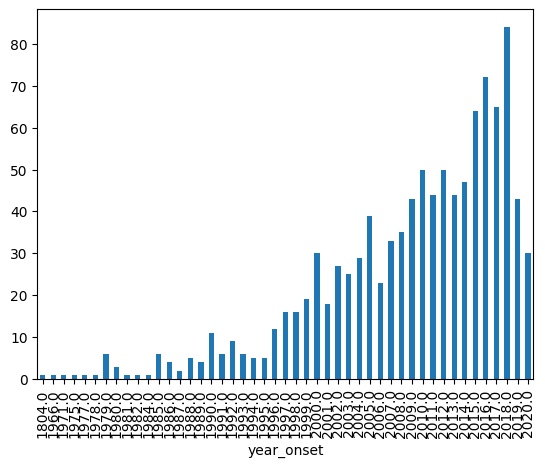

In [8]:
# show count df for `year_onset`
onset_year_counts = df_cleaned['year_onset'].value_counts().sort_index()
# make a bar plot
onset_year_counts.plot(kind='bar')

## Reason to remove year or date variables
The task is to classifying types of MS. Year produced limited information about the disease classicification. In addition, both variable has more data associated with 2020, so it is hard to bin the years without expert knowledge. Including the years as one-hot encoded categories also increase the degree of freedom dramatically. 

In [9]:
# Remove year_onset column and DMT_year_bin
df_cleaned = df_cleaned.drop(columns=['year_onset', 'DMT_year_bin'])

In [11]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1141 entries, C_1005 to P_992
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   report_source                   1141 non-null   object 
 1   age_in_cat                      1141 non-null   int64  
 2   bmi_in_cat2                     890 non-null    object 
 3   covid19_admission_hospital      1141 non-null   object 
 4   covid19_confirmed_case          1141 non-null   object 
 5   covid19_diagnosis               1141 non-null   object 
 6   covid19_has_symptoms            1133 non-null   object 
 7   covid19_outcome_recovered       1141 non-null   object 
 8   covid19_self_isolation          1126 non-null   object 
 9   covid19_sympt_chills            248 non-null    object 
 10  covid19_sympt_dry_cough         281 non-null    object 
 11  covid19_sympt_fatigue           291 non-null    object 
 12  covid19_sympt_fever             2

### one-hot encode the `df_cleaned` with NAN value being assigned to another level

In [14]:
# Deal with int64 and float64 variables
df_cleaned['age_in_cat'] = df_cleaned['age_in_cat'].astype('category')
df_cleaned['covid19_outcome_levels_2'] = df_cleaned['covid19_outcome_levels_2'].astype('category')
df_cleaned['duration_treatment_cat2'] = df_cleaned['duration_treatment_cat2'].astype('category')

# Identify columns with NaN values
columns_with_na = df_cleaned.columns[df_cleaned.isnull().any()]

# Apply pd.get_dummies() with dummy_na=True to columns with NaN values
df_with_na_dummies = pd.get_dummies(df_cleaned[columns_with_na], dummy_na=True)

# Apply pd.get_dummies() without dummy_na to the rest of the columns
df_without_na_dummies = pd.get_dummies(df_cleaned.drop(columns_with_na, axis=1))

# Concatenate the results
df_cleaned_OH = pd.concat([df_with_na_dummies, df_without_na_dummies], axis=1)
df_cleaned_OH = df_cleaned_OH.astype(int)
# Display the info of the one-hot encoded DataFrame
print(df_cleaned_OH.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1141 entries, C_1005 to P_992
Columns: 116 entries, bmi_in_cat2_not_overweight to has_comorbidities.2_yes
dtypes: int32(116)
memory usage: 558.2+ KB
None


In [ ]:
# save it to a csv file
df_cleaned_OH.to_csv('GDSI_OpenDataset_Final_cleaned_OH.csv')